This program uses the exponential probability distribution to randomly generate the arrival times of customers to an arbitrary establishment, as well as the time it takes to serve them.

The parameters are the following:

* The average customer service rate is 15 customers per hour, served by 3 cashiers.
* The average customer arrival rate is 12 customers per hour.

The next metrics must be calculated:

1. Total number of customers served in the day
2. Average wait time per customer
3. Average idle time per cashier
4. Maximum waiting time for a customer
5. Minimum waiting time for a customer
6. Effective cashier work time

This data will help determine whether to maintain, increase or decrease the number of boxes.

In [1]:
# Importing libraries
import numpy
import simpy
import matplotlib.pyplot as plt
import datetime as dt
import os

**Note:** simulation will be performed in minutes.

In [2]:
# A seed is defined for the random number generator, so that the results are reproducible
seed = 0
numpy.random.seed(seed)

In [3]:
# Functions to generate random variables

# Used for the simulation with the exponential distribution
def generate_arrival_time(lambda_arrival):
    return round(
        numpy.random.exponential(1 / lambda_arrival) * 60
    )

def generate_service_time(lambda_service):
    return round(
        numpy.random.exponential(1 / lambda_service) * 60
    )

# Used for the simulation with the Poisson distribution
def generate_customers_amount(lambda_arrival):
    return numpy.random.poisson(lambda_arrival / 60, 1)[0] # lambda_arrival is divided by 60 to obtain the average arrival rate per minute

In [4]:
# An interface which will make possible to decide where the output messages of the simulation will be registered
class MessageProcessor:
    def __init__(self,):
        pass

    def process(self, message):
        pass

    def stop(self):
        pass

# To store simulation results in a file
class FileMessageProcessor(MessageProcessor):
    def __init__(self, file_path):
        self.file_path = file_path
        self.file = open(self.file_path, "w")

    def process(self, message):
        self.file.write(message + "\n")

    def stop(self):
        self.file.close()

# To print simulation results in the console
class ConsoleMessageProcessor(MessageProcessor):
    def __init__(self,):
        pass

    def process(self, message):
        print(message)

    def stop(self):
        pass

In [5]:
class Metrics:
    def __init__(self, simulation_time : int, cashiers : list[simpy.Resource] = []):
        self.total_customers = 0
        self.served_customers = 0
        self.effective_times = {}
        self.waiting_times = {}
        self.max_waiting_time = 0
        self.min_waiting_time = 0
        self.simulation_time = simulation_time
        self.cashiers = cashiers

    def register_customer(self):
        self.total_customers += 1

    def register_served_customer(self):
        self.served_customers += 1

    def register_waiting_time(self, cashier : simpy.Resource, waiting_time : int):

        if waiting_time > self.max_waiting_time:
            self.max_waiting_time = waiting_time

        if waiting_time < self.min_waiting_time:
            self.min_waiting_time = waiting_time

        if cashier in self.waiting_times:
            self.waiting_times[cashier] = self.waiting_times[cashier] + waiting_time
        else:
            self.waiting_times[cashier] = waiting_time

    def register_effective_time(self, cashier : simpy.Resource, effective_time : int):
        if cashier in self.effective_times:
            self.effective_times[cashier] = self.effective_times[cashier] + effective_time
        else:
            self.effective_times[cashier] = effective_time

    def total_waiting_time(self):    
        return sum((self.waiting_times[cashier] for cashier in self.cashiers))

    def waiting_time_per_cashier(self, cashier : simpy.Resource):
        return self.waiting_times[cashier]

    def average_waiting_time(self):
        return self.total_waiting_time() / self.served_customers

    def total_effective_time(self):
        return sum((self.effective_times[cashier] for cashier in self.cashiers))

    def effective_time_per_cashier(self, cashier : simpy.Resource):
        return self.effective_times[cashier]

    def average_effective_time(self):
        return self.total_effective_time() / len(self.cashiers)

    def restart(self):
        self.total_customers = 0
        self.served_customers = 0
        self.waiting_times = {}
        self.effective_times = {}
        self.max_waiting_time = 0
        self.min_waiting_time = 0

In [6]:
# To report the simulation time in hh:mm format
def desc_minutes(start_time, minutes):
    return (
        dt.datetime.combine(dt.date.today(), start_time) + dt.timedelta(minutes=minutes)
    ).strftime("%H:%M")

In [7]:
# Function that selects the cashier that will be released first
def decide_best_cashier(cashiers, remaining_times):
    
        min_time = remaining_times[cashiers[0]]
        best_cashier = cashiers[0]
        
        for cashier in cashiers:
            if remaining_times[cashier] < min_time:
                min_time = remaining_times[cashier]
                best_cashier = cashier
    
        return best_cashier

In [8]:
def serve_customer(
    env,
    customer_id,
    cashier,
    cashier_id,
    service_time,
    start_time,
    metrics_monitor : Metrics,
    message_processor : MessageProcessor
):

    # Register the arrival of the customer
    arrival_time = env.now
    message = f"Customer #{customer_id} arrives at the queue at {desc_minutes(start_time, arrival_time)}\n"
    message_processor.process(message)
    
    with cashier.request() as request:

        # Wait to be served
        yield request

        # Serve the customer
        service_start_time = env.now
        message = f"Customer #{customer_id} is served at cashier #{cashier_id} at {desc_minutes(start_time, service_start_time)}\n"
        message_processor.process(message)
        yield env.timeout(service_time)

        # Register the departure of the customer
        metrics_monitor.register_effective_time(cashier, service_time)
        metrics_monitor.register_served_customer()
        message = f"Customer #{customer_id} finishes being served at {desc_minutes(start_time, env.now)}\n"
        message_processor.process(message)
        
        # Calculate the waiting time
        waiting_time = service_start_time - arrival_time
        metrics_monitor.register_waiting_time(cashier, waiting_time)

In [9]:
def exponential_queue_system(
    env,
    arrival_rate,
    service_rate,
    cashiers,
    remaining_times,
    start_time,
    metrics_monitor : Metrics,
    message_processor : MessageProcessor
):

    """
        This process is in charge of serving the customers that arrive to the queue system.
        Through an exponential distribution random variable, the time that the next customer will
        arrive is generated.
    """

    customer_id = 0

    while True:

        yield env.timeout(generate_arrival_time(arrival_rate))
        
        customer_id += 1
        metrics_monitor.register_customer()
        
        # Selects the cashier that will be released first
        best_cashier = decide_best_cashier(cashiers, remaining_times)
        cashier_id = cashiers.index(best_cashier) + 1

        service_time = generate_service_time(service_rate/len(cashiers))
        # Register the service time of the customer for the cashier
        remaining_times[best_cashier] += service_time
        
        # Start the serving customer process
        env.process(
            serve_customer(env, customer_id, best_cashier, cashier_id, service_time, start_time, metrics_monitor, message_processor)
        )

In [10]:
# The process that monitors the state of the cashiers is declared
def decrease_remaining_time(env, cashiers, remaining_times):
    
        """
            This process is in charge of decreasing the remaining attention time of each cashier minute by minute.
            This allows to know this info with greater precision, since in the customer service process
            only the moment when the service begins and ends is known, but when a new customer arrives
            it cannot be known exactly how much progress has been made in the current customer's service,
            so choosing the most optimal cashier requires greater precision.
    
            * Note: If the remaining service time is 0, it means that the cashier is free, so
            it should no subtract anything to the remaining service time.
        """
    
        while True:
    
            yield env.timeout(1)
    
            for cashier in cashiers:
                
                remaining_service_time = remaining_times[cashier]
                
                if remaining_service_time > 0:
                    remaining_times[cashier] -= 1

In [11]:
def poisson_queue_system(
    env,
    arrival_rate,
    service_rate,
    cashiers,
    remaining_times,
    start_time,
    metrics_monitor : Metrics,
    message_processor : MessageProcessor
):

    """
        This process is in charge of serving the customers that arrive to the queue system.
        A poisson distribution is used to generate random variables, which are used to
        determine the amount of customers that will arrive in the current minute.
    """

    customer_id = 0

    while True:

        yield env.timeout(1)
        
        # Decrease the remaining service time of each cashier
        for cashier in cashiers:
            
            remaining_service_time = remaining_times[cashier]
            
            if remaining_service_time > 0:
                remaining_times[cashier] -= 1

        # Generate the amount of customers that will arrive in the current minute
        customers_amount = generate_customers_amount(arrival_rate)
        
        # Serve the customers that arrived in the current minute
        for customer in range(customers_amount):
            
            customer_id += 1
            metrics_monitor.register_customer()

            # Selectc the cashier that will be released first
            best_cashier = decide_best_cashier(cashiers, remaining_times)
            cashier_id = cashiers.index(best_cashier) + 1

            # Generate the service time of the customer
            service_time = generate_service_time(service_rate/len(cashiers))
            remaining_times[best_cashier] += service_time
            
            # Start the serving customer process
            env.process(
                serve_customer(env, customer_id, best_cashier, cashier_id, service_time, start_time, metrics_monitor, message_processor)
            )

In [12]:
def exp_simulate(
    env : simpy.Environment,
    simulation_time : int,
    arrival_rate,
    service_rate,
    cashiers,
    remaining_times,
    start_time,
    metrics_monitor : Metrics,
    message_processor : MessageProcessor
):
    env.process(
        exponential_queue_system(
            env,
            arrival_rate,
            service_rate,
            cashiers,
            remaining_times,
            start_time,
            metrics_monitor,
            message_processor
        )
    )
    env.process(
        decrease_remaining_time(
            env,
            cashiers,
            remaining_times
        )
    )
    env.run(until=simulation_time)

def poisson_simulate(
    env : simpy.Environment,
    simulation_time : int,
    arrival_rate,
    service_rate,
    cashiers,
    remaining_times,
    start_time,
    metrics_monitor : Metrics,
    message_processor : MessageProcessor
):
    env.process(
        poisson_queue_system(
            env,
            arrival_rate,
            service_rate,
            cashiers,
            remaining_times,
            start_time,
            metrics_monitor,
            message_processor
        )
    )
    env.run(until=simulation_time)

In [13]:
def run_simulation(
    env : simpy.Environment,
    simulation_time : int,
    start_time : dt.time,
    dist : str,
    n_cashiers : int,
    arrival_rate : float,
    service_rate : float,
    metrics_monitor : Metrics,
    message_processor : MessageProcessor = ConsoleMessageProcessor(),
):

    """
        This function is in charge of running the queue system simulation, using minutes as time unit.

        It is possible to indicate the probability distribution of customer arrivals, either exponential
        (which will calculate the time it takes for one customer to arrive after another) or Poisson
        (which will calculate the amount of customers that arrive in a minute).

        * Note: If lambda is indicated in hours, the lambda_hours parameter must be indicated as true.

        @param env: Simulation environment
        @param simulation_time: Simulation duration in minutes
        @param start_time: Simulation start time
        @param dist: Customer arrival probability distribution ("exp" or "poi")
        @param n_cashiers: Number of cashiers
        @param arrival_rate: Average customer arrival rate per hour
        @param service_rate: Average customer service rate per hour
        @param metrics_monitor: Object that stores simulation data for later analysis
        @param message_processor: Message processor, by default it is shown in console
    """
    
    # Create the cashiers
    cashiers = [simpy.Resource(env, capacity=1) for i in range(n_cashiers)]
    metrics_monitor.cashiers = cashiers

    # This dictionary stores the remaining service time of each cashier
    remaining_times = {}
    for cashier in cashiers:
        remaining_times[cashier] = 0

    # Run the simulation according to the indicated probability distribution
    if dist == "exp":
        exp_simulate(env, simulation_time, arrival_rate, service_rate, cashiers, remaining_times, start_time, metrics_monitor, message_processor)
    elif dist == "poi":
        poisson_simulate(env, simulation_time, arrival_rate, service_rate, cashiers, remaining_times, start_time, metrics_monitor, message_processor)
    else:
        raise Exception("Invalid distribution")

    # Inform the message processor that the simulation has finished
    message_processor.stop()

In [14]:
# Calculate simulation time
start_time = dt.time(7, 0, 0) # 7:00 am
end_time = dt.time(22, 0, 0) # 10:00 pm
simulation_time = (end_time.hour - start_time.hour) * 60 # Simulation time in minutes

metrics_monitor = Metrics(simulation_time)

# Run the simulation
run_simulation(
    env = simpy.Environment(),
    simulation_time = simulation_time,
    start_time = start_time,
    dist = "exp", # Customer arrival probability distribution ("exp" or "poi")
    n_cashiers = 3,
    arrival_rate = 12,
    service_rate = 15,
    metrics_monitor = metrics_monitor,
)

Customer #1 arrives at the queue at 07:04

Customer #1 is served at cashier #1 at 07:04

Customer #2 arrives at the queue at 07:09

Customer #2 is served at cashier #2 at 07:09

Customer #3 arrives at the queue at 07:12

Customer #3 is served at cashier #3 at 07:12

Customer #4 arrives at the queue at 07:15

Customer #2 finishes being served at 07:18

Customer #4 is served at cashier #2 at 07:18

Customer #1 finishes being served at 07:19

Customer #3 finishes being served at 07:24

Customer #5 arrives at the queue at 07:32

Customer #5 is served at cashier #1 at 07:32

Customer #5 finishes being served at 07:38

Customer #6 arrives at the queue at 07:40

Customer #6 is served at cashier #1 at 07:40

Customer #7 arrives at the queue at 07:44

Customer #8 arrives at the queue at 07:44

Customer #7 is served at cashier #3 at 07:44

Customer #9 arrives at the queue at 07:44

Customer #4 finishes being served at 07:45

Customer #8 is served at cashier #2 at 07:45

Customer #8 finishes bein

In [15]:
# Report simulation results
print(f"🙂   Customers that arrived: {metrics_monitor.total_customers}")
print(f"😊✨ Customers served: {metrics_monitor.served_customers}")
print(f"⌛    Average waiting time: {int(metrics_monitor.average_waiting_time())} minutes")
print(f"⌛😡  Maximum waiting time: {metrics_monitor.max_waiting_time} minutes")
print(f"⌛💚  Minimum waiting time: {metrics_monitor.min_waiting_time} minutes")

print(f"🔨    Effective time worked by cashier:")
i = 1
for time in metrics_monitor.effective_times.values():
    print(f"\tCashier #{i}: {time} min.")
    i += 1

print(f"😴   Idle time by cashier:")
i = 1
for time in metrics_monitor.effective_times.values():
    print(f"\tCashier #{i}: {simulation_time - time} min.")
    i += 1

🙂   Customers that arrived: 181
😊✨ Customers served: 177
⌛    Average waiting time: 5 minutes
⌛😡  Maximum waiting time: 33 minutes
⌛💚  Minimum waiting time: 0 minutes
🔨    Effective time worked by cashier:
	Cashier #1: 657 min.
	Cashier #2: 725 min.
	Cashier #3: 570 min.
😴   Idle time by cashier:
	Cashier #1: 243 min.
	Cashier #2: 175 min.
	Cashier #3: 330 min.


In [16]:
# The following code will run a simulation for multiple numbers of cashiers, in order to determine the optimal number
# of cashiers for the system, for both the exponential and Poisson distributions.

dists = ("exp", "poi")
n_cashiers = list(range(1,10,2)) # We will simulate with 1, 3, 5, 7 and 9 cashiers

served_customers_per_cashier = []
average_waiting_times = []
average_global_effective_times = []

variables_to_plot = [
    ("Served customers", served_customers_per_cashier),
    ("Average waiting time (min.)", average_waiting_times),
    ("Average global effective time (hrs.)", average_global_effective_times),
]

In [17]:
def colors():
    yield "red"
    yield "green"
    yield "blue"
    yield "orange"
    yield "purple"
    yield "brown"
    yield "pink"
    yield "gray"
    yield "olive"
    yield "cyan"

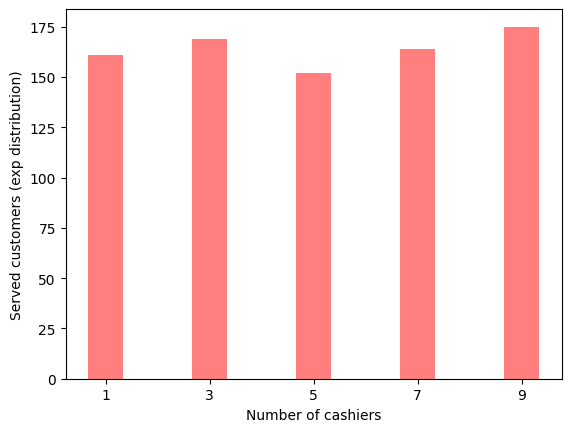

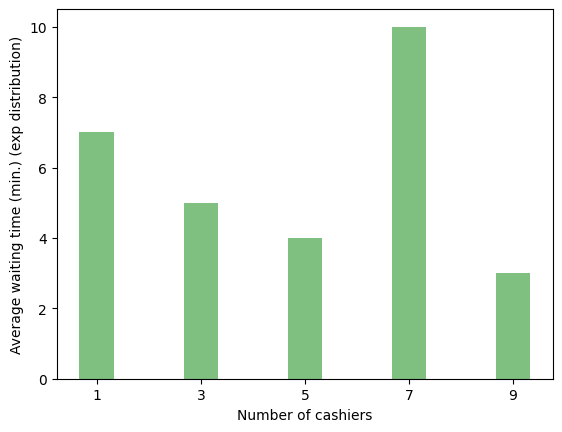

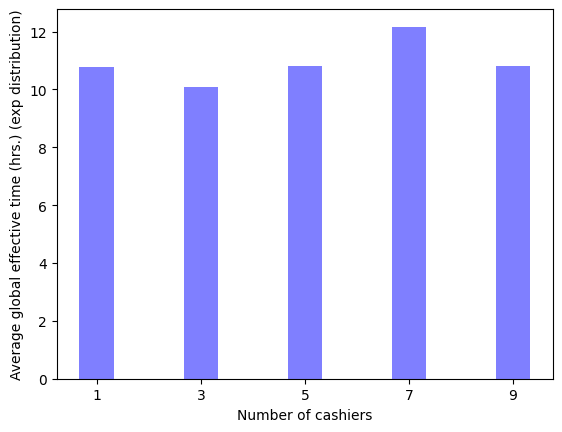

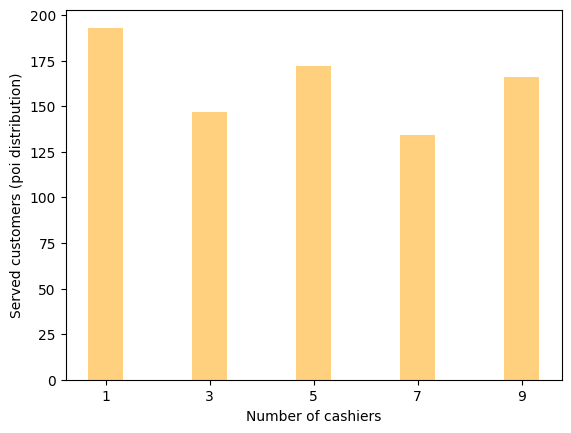

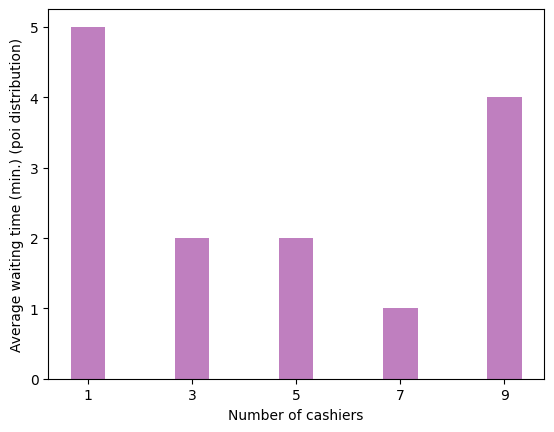

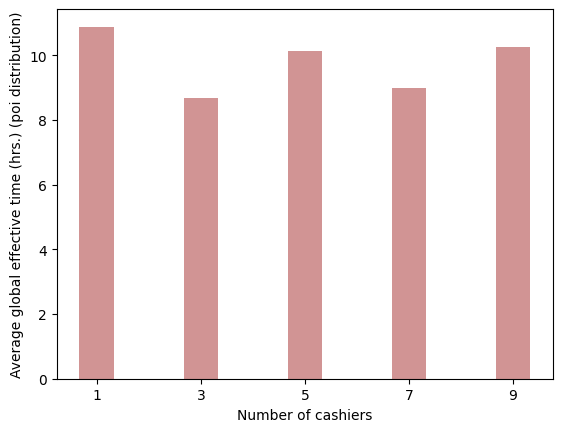

In [18]:
# The results are plotted
bar_width = 1 / len(variables_to_plot)
positions = numpy.arange(len(n_cashiers))
colors_gen = colors()
metrics_monitor = Metrics(simulation_time)

# Create the directory for the results of each run.
try:
    if not os.path.exists("run_results"):
        os.mkdir("run_results")
except:
    raise Exception("Could not create directory for run results")

for dist in dists:
    
        colors_gen_ = colors_gen
    
        for n_cashier in n_cashiers:
        
            results_file_path = f"run_results/run_{dist}_{n_cashier}_cashiers.txt"
            message_processor = FileMessageProcessor(results_file_path)
    
            run_simulation(
                env = simpy.Environment(),
                simulation_time = simulation_time,
                start_time = start_time,
                dist = dist,
                n_cashiers = n_cashier,
                arrival_rate = 12,
                service_rate = 15,
                metrics_monitor = metrics_monitor,
                message_processor = message_processor,
            )
    
            served_customers_per_cashier.append(metrics_monitor.served_customers)
            average_waiting_times.append(int(metrics_monitor.average_waiting_time()))
            average_global_effective_times.append(metrics_monitor.average_effective_time() / 60)
            # Clear the metrics monitor for the next distribution
            metrics_monitor.restart()
    
        for desc, arg_list in variables_to_plot:
            
            plt.bar(positions, arg_list, align="center", alpha=0.5, color=next(colors_gen), width=bar_width)
            plt.xticks(positions, n_cashiers)
            plt.xlabel("Number of cashiers")
            plt.ylabel(f"{desc} ({dist} distribution)")
            plt.show()
            # Clear the list for the next run
            arg_list.clear()

